## Carregamento dos Dados e Preparação do Ambiente

### Instalação de Pacotes

In [ ]:
! pip install pandas numpy matplotlib scikit-learn imbalanced-learn

### Importação de Bibliotecas
Na célula seguinte são importadas bibliotecas e métodos que serão utilizadas repetidamente ao longo da análise.

In [2]:
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report, f1_score,
    ConfusionMatrixDisplay
)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from utils.visualization import (
    plot_metrics_by_class, print_summary_metrics,
    print_summary_metrics_latex
)

### Definição de Constantes Auxiliares
Na célula seguinte são definidas constantes utilitárias diversas que serão usadas ao longo da análise.

In [3]:
random_state = 42

initial_config = {
    'hidden_layer_sizes': (64, 32),
    'activation': 'relu',
    'solver': 'adam',
    'alpha': 1e-4,
    'learning_rate': 'adaptive',
    'max_iter': 300,
    'early_stopping': True,
    'random_state': random_state
}

test_ratio = 0.15

train_ratio_holdout = 0.70
valid_ratio_holdout = 0.15

numeric_attrs = ["idade_paciente", "dias_sintomas_notificacao"]

### Obtenção e análise dos dados
O código abaixo carrega o dataset utilizando as funções do scikit-learn e mostra algumas informações básicas sobre os dados

In [4]:
df_sinan_processed = pd.read_csv("../data/3_gold/dataset-processed.csv")

X = df_sinan_processed.drop("severity", axis=1)
y = df_sinan_processed["severity"]

feature_names = X.columns.tolist()
target_names = ["low_risk", "alarm", "severe"]

y = y.map({name: idx for idx, name in enumerate(target_names)})

### Separação do Conjunto de Teste
Essa separação é realizada independentemente do algoritmo utilizado para particionar os dados entre treino e validação (holdout ou LOOCV).

In [5]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_ratio, random_state=random_state, stratify=y)

### Particionamento dos Dados (Holdout)

In [6]:
# Fazendo a segunda divisão, para gerar o conjunto de treino e validação
final_test_size = valid_ratio_holdout / (train_ratio_holdout + test_ratio)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=final_test_size, random_state=random_state, stratify=y_temp)

# Normalizando atributos numéricos
for col in numeric_attrs:
    mean = X_train[col].mean()
    std = X_train[col].std()
    X_train[col] = (X_train[col] - mean) / (std + 1e-8)
    X_valid[col] = (X_valid[col] - mean) / (std + 1e-8)
    X_test[col] = (X_test[col] - mean) / (std + 1e-8)

print(f"Conjuntos gerados com as seguintes proporções: ")
print(f"  Treinamento: {X_train.shape}")
print(f"  Validação: {X_valid.shape}")
print(f"  Teste: {X_test.shape}")

Conjuntos gerados com as seguintes proporções: 
  Treinamento: (501841, 42)
  Validação: (107538, 42)
  Teste: (107538, 42)


## Amostragem de Dados

### Amostragem com SMOTE

In [7]:
X_train_full = np.concatenate((X_train, X_valid), axis=0)
y_train_full = np.concatenate((y_train, y_valid), axis=0)

class_counts = Counter(y_train_full)

under_sampler = RandomUnderSampler(sampling_strategy={0: class_counts[1]}, random_state=random_state)
over_sampler = SMOTE(sampling_strategy={2: class_counts[1]}, random_state=random_state)

pipeline = Pipeline([
    ('under', under_sampler),
    ('over', over_sampler)
])

X_train_final, y_train_final = pipeline.fit_resample(X_train_full, y_train_full)

mlp = MLPClassifier(**initial_config)
mlp.fit(X_train_final, y_train_final)

y_pred = mlp.predict(X_test)

f1_test = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f"F1-Macro (Dados de Teste): {f1_test:.3f}")

F1-Macro (Dados de Teste): 0.518


/home/gabriel/Documents/UFRGS/2025-2/ML/TF/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


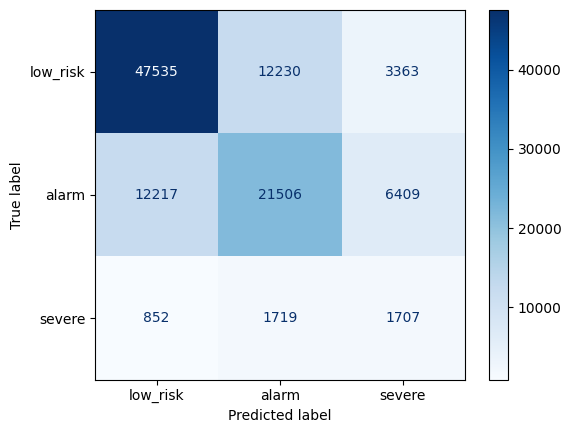

In [8]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=target_names, cmap=plt.cm.Blues)

plt.savefig("../figures/mlp_confusion_matrix.pdf")
plt.show()

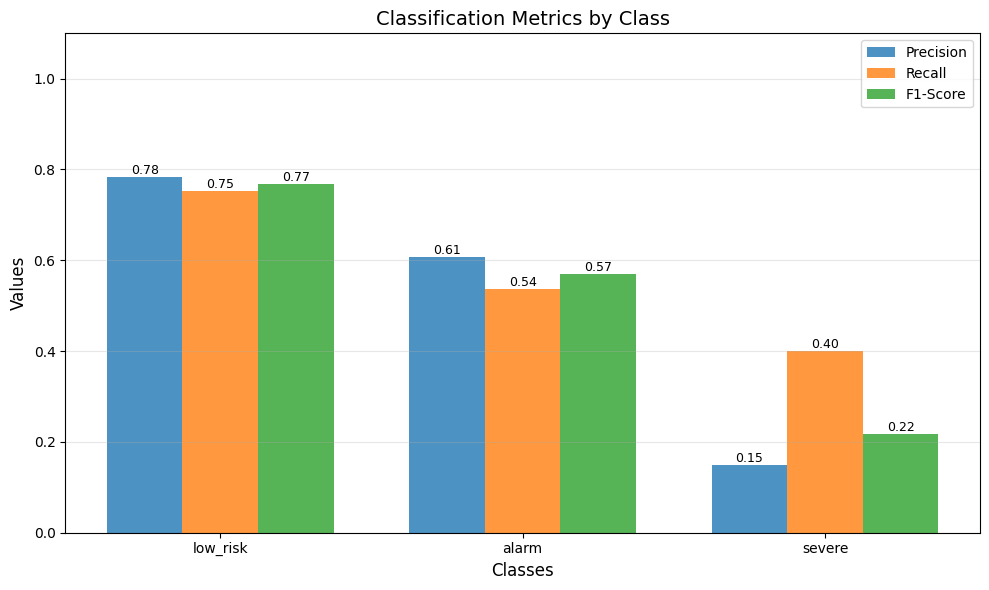

In [9]:
fig, ax, report_dict = plot_metrics_by_class(y_test, y_pred, target_names=target_names)

plt.savefig("../figures/mlp_metrics_by_class.pdf")
plt.show()

In [10]:
print_summary_metrics(report_dict)


              CLASSIFICATION METRICS (SUMMARY)              

Accuracy: 0.658

                        Precision       Recall     F1-Score
------------------------------------------------------------
Macro Avg                   0.513        0.563        0.518
Weighted Avg                0.693        0.658        0.672



In [11]:
print_summary_metrics_latex(report_dict)

\begin{table}
\caption{Classification Metrics (Accuracy: 0.658)}
\label{tab:metrics}
\begin{tabular}{lrr}
\toprule
Metric & Macro Avg & Weighted Avg \\
\midrule
Precision & 0.513 & 0.693 \\
Recall & 0.563 & 0.658 \\
F1-Score & 0.518 & 0.672 \\
\bottomrule
\end{tabular}
\end{table}



In [12]:
report = classification_report(y_test, y_pred, target_names=target_names, zero_division=0)
print("Relatório de Classificação:\n", report)

Relatório de Classificação:
               precision    recall  f1-score   support

    low_risk       0.78      0.75      0.77     63128
       alarm       0.61      0.54      0.57     40132
      severe       0.15      0.40      0.22      4278

    accuracy                           0.66    107538
   macro avg       0.51      0.56      0.52    107538
weighted avg       0.69      0.66      0.67    107538

